# Neural Architecture Search for Large Language Models


This notebook shows how to use neural architecture search (NAS) to compress a large language model fine-tuned on some target task.
Our NAS approach consists of two steps:
- We first fine-tune the pre-trained model on the target task, by weight-sharing based NAS training strategies. The idea is to treat the pre-trained model as a 'super-networks' that constains a large but finite number of sub-networks. This requires us to update in each iterations only parts of the network to avoid that sub-networks co-adapt.
- In the second step, we use multi-objective search to find a set of sub-networks that optimally trade-off between parameter count and validation error on the target task.

At the end we can plot the so-called Pareto set of architecture and select the final model that gives us the right trade-off between model size and validation error.


**Limitations**

- So far we only support the BERT and GPT2 model family
- For now we use Syne Tune for the multi-objective search. In the future we will use AMT, which allows us to distribute the search across m


## Install requirements

Before we get started, we have to install all requirements

In [ ]:
!pip install -r requirements.txt

## Imports

In [1]:
import logging
import numpy as np
import evaluate
import torch

from datasets import load_dataset
from torch.utils.data import DataLoader, Subset

from transformers import (
    AutoTokenizer,
    default_data_collator,
    TrainingArguments,
    AutoModelForSequenceClassification,
    AutoConfig
)

from training import train_supernetwork
from search import multi_objective_search
from parse_model import get_final_model

logger = logging.getLogger(__name__)

## Hyperparameters

We define different hyperparameters for our model and dataset.

In [2]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = 'rte'
model_type = 'bert-base-cased'
output_dir = 'nas_output_dir'
max_seq_length = 128
per_device_train_batch_size = 8
per_device_eval_batch_size = 8

## Load Dataset and Evaluation Metric

We load the RTE dataset from the GLUE benchmarking suite via the dataset library from HuggingFace 

In [3]:
raw_datasets = load_dataset(
    "glue", task_name
)

metric = evaluate.load("glue", task_name)

  0%|          | 0/3 [00:00<?, ?it/s]

## Data Preprocessing

This follows the standard Huggingface code from this example: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_type)

if model_type.startswith("gpt2"):
    tokenizer.pad_token = tokenizer.eos_token

# Preprocessing the raw_datasets
sentence1_key, sentence2_key = task_to_keys[task_name]

# Padding strategy
padding = "max_length"

max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(
        *args, padding=padding, max_length=max_seq_length, truncation=True
    )

    return result

raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset",
)

label_list = raw_datasets["train"].features["label"].names
num_labels = len(label_list)

## Split Dataset in Training / Validation

In [5]:
train_dataset = raw_datasets["train"]
test_dataset = raw_datasets[
    "validation_matched" if task_name == "mnli" else "validation"
]

train_dataset = train_dataset.remove_columns(["idx"])
test_dataset = test_dataset.remove_columns(["idx"])

split = train_dataset.train_test_split(
    train_size=0.7, seed=0
)  # fix seed to make results reproducible
valid_dataset = split["test"]


data_collator = default_data_collator

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=per_device_train_batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    valid_dataset,
    batch_size=per_device_eval_batch_size,
    collate_fn=data_collator,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=per_device_eval_batch_size,
    collate_fn=data_collator,
)

## Load pre-trained Model

In [6]:
config = AutoConfig.from_pretrained(
    model_type,
    num_labels=num_labels,
    finetuning_task=task_name,
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_type,
    config=config,
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Train weight-sharing based Super-Network

In [11]:
training_args = TrainingArguments(output_dir=output_dir)
training_args.search_space = 'small'
training_args.use_accelerate = False # set this to True to distribute training on multiple GPUs
training_args.is_regression = False  # set this to True if your dataset is a regression dataset, for example STSB
training_args.save_strategy = "epoch"
training_args.log_dir = '.log_dir'

train_supernetwork(model, train_dataloader, eval_dataloader, metric, training_args)

  0%|          | 0/936 [00:00<?, ?it/s]

## Multi-objective search for sub-networks

In [12]:
metric_name = 'accuracy'
training_args.num_samples = 5
pareto_set = multi_objective_search(model, eval_dataloader, metric, metric_name, training_args)

## Visualize Results

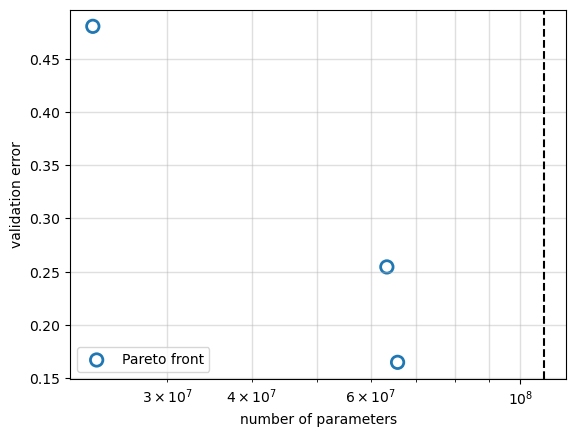

In [13]:
import matplotlib.pyplot as plt

n_params_original_model = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )
plt.axvline(n_params_original_model, color='black', linestyle='--')

plt.scatter(pareto_set['params'], pareto_set['error'], marker='o', s=80,
            facecolors='none', edgecolors='C0', linewidth=2, label='Pareto front')
plt.xlabel('number of parameters')
plt.ylabel('validation error')
plt.legend()
plt.xscale('log')
plt.grid(linewidth='1', alpha=0.4, which="both")

## Select Final Model

In [15]:
architecture_definition = pareto_set['configs'][0]
new_model = get_final_model(original_model=model, architecture_definition=architecture_definition)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

n_params_new_model = sum(
            p.numel() for p in new_model.parameters() if p.requires_grad
        )
print(n_params_new_model)

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs\
        = new_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)


    metric.add_batch(predictions=predictions, references=batch["labels"])

eval_metric = metric.compute()
print(1 - eval_metric[metric_name])

23257346.0 0.48058902275769744
{'layer_mha_0': 0, 'layer_ffn_0': 0, 'layer_mha_1': 0, 'layer_ffn_1': 0, 'layer_mha_2': 0, 'layer_ffn_2': 0, 'layer_mha_3': 0, 'layer_ffn_3': 0, 'layer_mha_4': 0, 'layer_ffn_4': 0, 'layer_mha_5': 0, 'layer_ffn_5': 0, 'layer_mha_6': 0, 'layer_ffn_6': 0, 'layer_mha_7': 0, 'layer_ffn_7': 0, 'layer_mha_8': 0, 'layer_ffn_8': 0, 'layer_mha_9': 0, 'layer_ffn_9': 0, 'layer_mha_10': 0, 'layer_ffn_10': 0, 'layer_mha_11': 0, 'layer_ffn_11': 0}
23257346
0.48058902275769744
